# Changing the custom head to something smaller

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from sklearn.model_selection import train_test_split
import time

verbose = False  # should print out extra details?

%matplotlib inline

In [2]:
torch.cuda.set_device(0)   # Set default device to 1st gpu

In [3]:
print(f'FastAi: {fastai.__version__}')
print(f'Torch: {torch.__version__}')

FastAi: 1.0.52
Torch: 1.1.0


In [4]:
bs = 32  ## for out of memory
num_workers = 3  # set to 0 or 1 when using windows or kaggle
image_size = 224

In [5]:
data_fp = Path('data')
data_train = data_fp/'train'
sub_fp = Path('submission') 

In [6]:
# look at folder tree
!tree -d {data_fp}

data
├── models
├── test
├── test_crop_224
├── train
└── train_playground
    └── models

6 directories


# Looking at the data

In [7]:
labels = pd.read_csv(data_fp/'train.csv')
print(labels.shape)
print(f'Number of classes: {len(labels.Id.unique()):,}')
labels.head()

(25361, 2)
Number of classes: 5,005


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


## Split data into training and validation set
Because the data is extremely unbalance where it contains classes with only one sample, we cannot use a random sampling method.   
Fastai will get an error when there is a class in the validation set and not in training set. [link](https://github.com/fastai/fastai/issues/1273)

In addition, we cannot use StratifiedShuffleSplit because the minimum number of groups for any class cannot be less than 2.   
Therefore, we will need to duplicate images for this to work. Instead, we will manually create a train and validation split. 

In [8]:
# ## Save code just in case for future use
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# ## split is decided by the Id column
# for train_index, val_index in sss.split(labels.index.values, labels.Id):
#     train_idx, val_idx = train_index, val_index  

In [9]:
class_counts = labels.Id.value_counts(sort=True, ascending=True)
print(f'The number of images: {class_counts.sum():,}')
print('{}'.format('='*20))
print(f'Number of classes with only one image: {sum(class_counts == 1):,}')
print(f'Percentage of classes with one image: {sum(class_counts == 1)/len(labels.Id.unique()):.0%}')
print('{}'.format('='*20))
print(f'Number of new_whate image: {class_counts["new_whale"].sum():,}')
print(f'Percentage of images are new_whale: {class_counts["new_whale"]/class_counts.sum()*100:0.0f}%')

The number of images: 25,361
Number of classes with only one image: 2,073
Percentage of classes with one image: 41%
Number of new_whate image: 9,664
Percentage of images are new_whale: 38%


In [10]:
class_counts[::-1][:5]  # top five most common class

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

### Stratified Split
Split the data such that classes with only 1 sample will go into training set and classes with 2+ will split randomly with ~20% into validation set. 

In [11]:
start_time = time.time()
## stratify sampling that can handle 
train_idx, val_idx = pd.Series(), pd.Series()
for name, group in labels.reset_index()[['index', 'Id']].groupby(['Id']):
    ## if a class only have 1 sample, just return that one
    if group.shape[0] == 1:
        train, val = group['index'], []
    ## split each group randomly and obtain their index
    else:
        train, val = train_test_split(group['index'], test_size=0.2, random_state=None)
    train_idx = train_idx.append(train)
    val_idx = val_idx.append(val)
    
print(f'It took {int(time.time() - start_time)} seconds')

It took 2 seconds


In [12]:
train_idx.head()

17289    17289
10133    10133
3072      3072
13881    13881
17649    17649
dtype: int64

In [13]:
## assess that the number of class are all accounted for in the training indexing
assert len(labels.loc[train_idx, 'Id'].unique()) == len(labels.Id.unique())
print('Number of class {}: {}'.format(len(labels.loc[train_idx, 'Id'].unique()), len(labels['Id'].unique())))
print('Percent of training split: {:.0%}'.format(len(train_idx)/labels.shape[0]))

Number of class 5005: 5005
Percent of training split: 76%


The training/validation split is off from the 80/20 split because classes with a small amount of images are harder to split with that ratio.  
For instance, classes with 2 images will do a 50/50 split such that atleast one is in training and validation. 

## Create ImageDataBunch

In [14]:
tfms = get_transforms(flip_vert=False, max_zoom=1)  ## remove vertical and zooming
if verbose: tfms  ## list of transformations done to the images. tfms[0] is for training and tfms[1] is for validation

In [15]:
src = (ImageList.from_df(path=data_fp, df=labels, cols='Image', folder='train')
                     # images' filepath are in a dataframe with column name 'Image'
                    .split_by_idx(val_idx)
                    # validations are not random and determined by the row indices
                    .label_from_df(cols='Id')
                    # classes for the images are in a dataframe with column name 'Id'
                    .add_test_folder())
                    # images to be use for inferences to the kaggle competition
if verbose: print(f'Type({type(src)})')
if verbose : print(src)  # show a summary of the datasets

In [16]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.transform(tfms, 
                          size=size,
                          resize_method=ResizeMethod.PAD,
                          padding_mode=padding_mode)
                .databunch(bs=bs, num_workers=num_workers)
                # creates a dataloader
                .normalize(imagenet_stats))
                # normalize the whale images with imagenet's mean and std because we are using a pretrained model

In [17]:
data = get_data(image_size, bs, 'border')

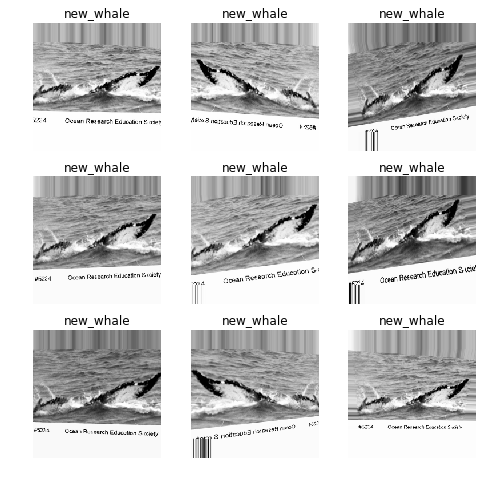

In [18]:
# Display examples of the transformation on a single image
def _plot(i,j,ax):
    x,y = data.train_ds[idx]
    x.show(ax,y=y)

idx = np.random.randint(len(data.train_ds))
plot_multi(_plot, 3, 3, figsize=(8,8))  ## show how the image is being transformed

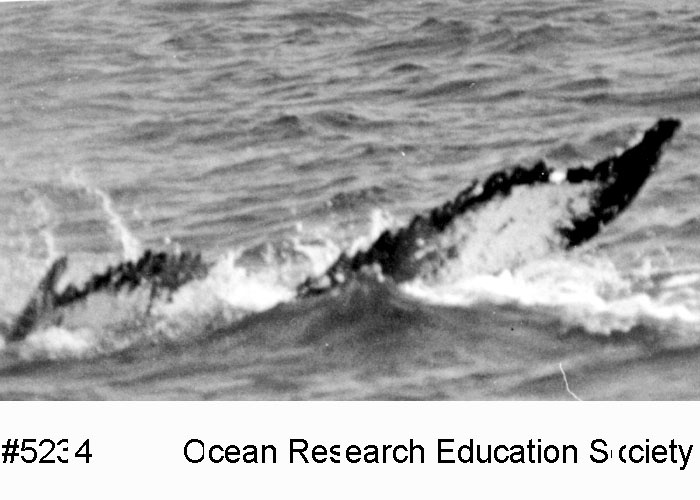

In [19]:
open_image(data.train_ds.items[idx]) # orginal image

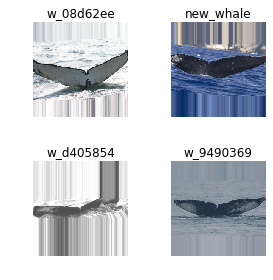

In [20]:
data.show_batch(rows=2, figsize=(4,4))  # this keeps crashing my computer

## Training

In [21]:
def mapr(input: torch.Tensor, targs: torch.LongTensor, mapn: int):
    "Compute the mean average precision"
    n = targs.shape[0]  # number for samples
    input = input.argsort(dim=-1, descending=True)[:,:mapn]
    targs = targs.view(n, -1)
    return ((input == targs).float()/torch.arange(1,mapn+1, device=input.device).float()).sum(dim=-1).mean()

map5 = partial(mapr, mapn=5)

Custom head that fastai makes
```
Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=5005, bias=True)
)
```

In [22]:
def get_learner():
    return cnn_learner(data=data, 
                    base_arch=models.resnet50, 
                    custom_head=nn.Sequential(AdaptiveConcatPool2d(), Flatten(), nn.BatchNorm1d(4096), nn.Dropout(), nn.Linear(4096, data.c)),
                    metrics=[accuracy, map5], 
                    pretrained=True)

In [23]:
# pre-trained = true means to use pre-trained weights and to freeze the body weights and only train the head
# the head will be replaced with: an AdaptiveConcatPool2d, Flatten, and blocks of [BatchNorm1d, Dropout, Linear, RelU]
learn = get_learner()

In [24]:
learn.model[1] # show the custom head that match with fastai v. 0.7

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5)
  (4): Linear(in_features=4096, out_features=5005, bias=True)
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


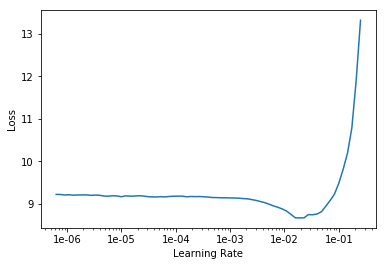

In [25]:
learn.lr_find()
learn.recorder.plot()

## Testing Learning Rate Range

In [26]:
lr_range = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]; lr_range

[0.0001, 0.0005, 0.001, 0.005, 0.01]

===========Learning Rate: 0.0001===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,6.113609,6.168614,0.302658,0.315745,04:13
1,5.459380,5.840550,0.325914,0.343973,04:12
2,5.104324,5.745367,0.332060,0.353547,04:12
3,5.069724,5.646998,0.337043,0.363386,04:12
4,4.892939,5.562636,0.346512,0.372882,04:12


===========Learning Rate: 0.0005===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,5.764770,5.754550,0.328405,0.351113,04:12
1,5.222328,5.432714,0.350664,0.381038,04:12
2,4.769331,5.277357,0.367110,0.402572,04:12
3,4.621830,5.076218,0.377076,0.415822,04:11
4,4.370306,5.007548,0.388372,0.433159,04:12


===========Learning Rate: 0.001===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,5.886178,5.742360,0.323256,0.350000,04:12
1,5.341246,5.443613,0.348173,0.385318,04:11
2,5.111616,5.033480,0.376412,0.415974,04:11
3,4.603180,4.939747,0.393522,0.437370,04:12
4,4.234656,4.952051,0.400664,0.445570,04:11


===========Learning Rate: 0.005===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,7.252558,7.776081,0.319767,0.323104,04:12
1,6.430094,16.460880,0.321096,0.325091,04:11
2,6.894504,6.407027,0.321096,0.326323,04:12
3,7.050398,7.370385,0.318272,0.321202,04:11
4,6.211617,7.263423,0.320266,0.324394,04:11


===========Learning Rate: 0.01===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,7.096357,7.969107,0.287209,0.298956,04:12
1,7.081839,6.797668,0.319767,0.321658,04:11
2,7.641788,13.616710,0.308472,0.316329,04:11
3,7.335464,8.048960,0.320930,0.322896,04:11
4,7.375189,10.397498,0.321096,0.323184,04:11


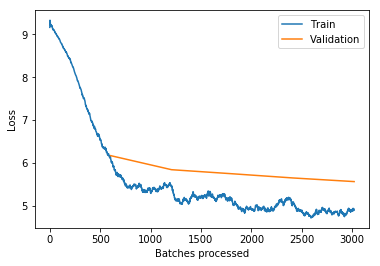

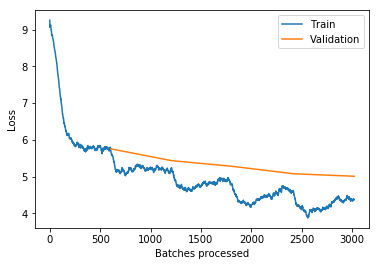

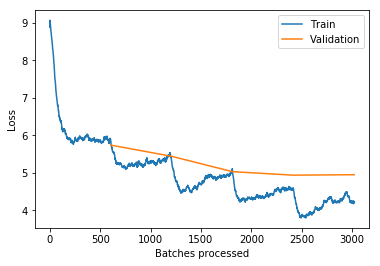

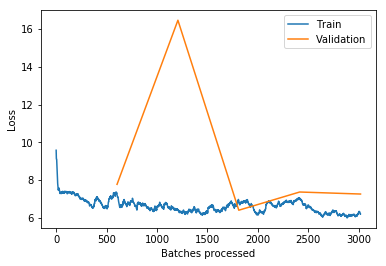

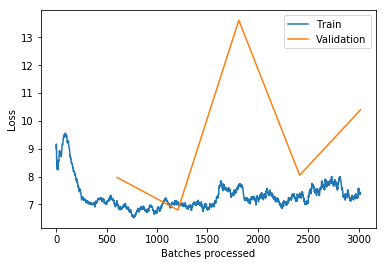

In [27]:
for lr in lr_range:
    print(f'===========Learning Rate: {lr}===========')
    learn = get_learner()
    learn.fit(5, lr)
    learn.recorder.plot_losses()

### Fine Tuning head

**Notes on learning rate** 
* lr = 2e-2                  
    * train every layer with the same lr
* r = slice(2e-2)           
    * train the head (final layers) with 2e-2 and the body with lr/3. divide by 3 b/c of batchnorm..
* lr = slice(1e-5, 2e-2)     
    * train the head with 2e-2, the first layers will get 1e-5 and the in between will get multiplical-equally spaces values between min/max

by default there are three layer groups. The body is split in half and th head is another. 

In [28]:
# how discriminative learning rate is created
test_lr = slice(1e-3, 8e-2)
even_mults(test_lr.start, test_lr.stop, 3)

array([0.001   , 0.008944, 0.08    ])

In [29]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, map5], pretrained=True)

In [30]:
learn.fit_one_cycle(5, 0.0051)

epoch,train_loss,valid_loss,accuracy,mapr,time
0,5.930397,6.108485,0.309635,0.320858,04:09
1,5.535772,5.826291,0.323920,0.336836,04:01
2,5.297760,5.634523,0.328405,0.349513,03:44


KeyboardInterrupt: 

In [ ]:
learn.recorder.plot_losses()

In [ ]:
print(learn.recorder.lrs[0], max(learn.recorder.lrs))
learn.recorder.plot_lr()

In [ ]:
## checkpoint! save model
learn.save('first_attempt-stage-1')

### Unfreeze and train on whole model with discriminative learning rate

In [ ]:
learn.unfreeze()  # train whole model now

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-4
n_cycles = 4

In [ ]:
losses = []
losses_val = []
for i in range(n_cycles):
    print(f'===========Cycle: {i}===========')
    learn.fit_one_cycle(10, slice(lr, lr/10), pct_start=0.3)
    losses.append(learn.recorder.losses)
    losses_val.append(learn.recorder.val_losses)
    learn.recorder.plot_losses()

In [ ]:
learn.save('first_attempt-stage-2')

## Plot the cycles on one plot

In [ ]:
loss = sum(losses, [])
iterations = [*range(len(loss))]

val = sum(losses_val, [])
val_iter = np.cumsum(learn.recorder.nb_batches*n_cycles)

In [ ]:
_, ax = plt.subplots(1,1, figsize=(16,6))
ax.plot(iterations, loss, label='Train')
ax.plot(val_iter, val, label='Validation')
ax.set_ylabel('Losses')
ax.set_xlabel('Batches processed')
for i in range(n_cycles):
    ax.axvline(x=i*604*10, color='black', linestyle='--', alpha=.1)
ax.legend()
plt.show()

## Get predictions. 

In [37]:
pred, _ = learn.get_preds(ds_type=DatasetType.Test)

In [38]:
pred.shape

torch.Size([7960, 5005])

In [39]:
def create_submission(preds, data, path, name, mapn=5):
    preds_sort = preds.argsort(dim=-1, descending=True)[:,:mapn]
    cls_np = np.asarray(data.classes)
    (pd.DataFrame({"Image": [fn.name for fn in data.test_ds.items],
                  "Id": [" ".join(cls_np[idx]) for idx in preds_sort.numpy()]})
        .to_csv(path/name, index=False))

In [40]:
create_submission(pred, learn.data, sub_fp,'testing3.csv')

In [41]:
pd.read_csv(sub_fp/'testing3.csv').head()

,Image,Id
0,a348f5ac5.jpg,new_whale w_cd4cb49 w_9b5109b w_2b65b34 w_90c9763
1,1b7ee8ac5.jpg,new_whale w_2b069ba w_9c506f6 w_08630fd w_6caff0f
2,a11d5558d.jpg,new_whale w_cd4cb49 w_e2372d6 w_fd3e556 w_16df050
3,51b4747d8.jpg,new_whale w_d405854 w_025911c w_2365d55 w_2745292
4,033304f3f.jpg,new_whale w_f765256 w_bfcad53 w_a8b34a0 w_0b1e4a6


In [43]:
!kaggle competitions submit -c humpback-whale-identification -f "./submission/testing3.csv" -m "classification_4_cycle"

100%|████████████████████████████████████████| 498k/498k [00:05<00:00, 85.5kB/s]
Successfully submitted to Humpback Whale Identification

Result is 
* private: 0.34826
* public: 0.32563

## Try TTA

In [96]:
pred, _ = learn.TTA(ds_type=DatasetType.Test)

In [97]:
pred.shape

torch.Size([7960, 5005])

In [95]:
pred[:2,:10]

tensor([[6.1019e-01, 1.1082e-05, 2.9527e-05, 5.1544e-04, 2.1349e-05, 1.8495e-05,
         1.7627e-05, 2.7016e-04, 9.9995e-06, 1.6105e-05],
        [9.3975e-01, 1.5889e-06, 2.1315e-06, 1.6173e-04, 3.5989e-06, 2.8795e-06,
         1.4814e-06, 4.4349e-05, 2.4315e-06, 2.8365e-06]])

In [107]:
sub_file = 'testing3_tta.csv'
create_submission(pred, learn.data, sub_fp, sub_file)
pd.read_csv(sub_fp/sub_file).head()

,Image,Id
0,a348f5ac5.jpg,new_whale w_cd4cb49 w_2b65b34 w_90c9763 w_9b5109b
1,1b7ee8ac5.jpg,new_whale w_6caff0f w_08630fd w_6cda039 w_9c506f6
2,a11d5558d.jpg,new_whale w_700ebb4 w_cd4cb49 w_16df050 w_e2372d6
3,51b4747d8.jpg,new_whale w_d405854 w_2365d55 w_bfcad53 w_025911c
4,033304f3f.jpg,new_whale w_f765256 w_bfcad53 w_a113b33 w_a8b34a0


In [108]:
!kaggle competitions submit -c humpback-whale-identification -f "./submission/"{sub_file} -m "classification_4_cycle_tta"

100%|█████████████████████████████████████████| 498k/498k [00:01<00:00, 266kB/s]
Successfully submitted to Humpback Whale Identification

Result is 
* private: 0.34290
* public: 0.32130